# Goal
Determine if yearly fantasy footbal stats can be used to predict next year's stats <br>
focus on year long stats to ignore huge week-to-week variation <br>
focus on wide recievers to simply any differences between position groups<br>
get stats from PFF.com

### Import data from source

filter data to just take WRs <br>
also filter to take the top 50% of targets - this is about 30, which is about 2 per game.  This is a reasonable metric to filter out the least targeted WRs <br>
Choose list of fields that could be relevant - this is largley a judgement call

In [376]:
import pandas as pd
import numpy as np

years = [2018,2019,2020,2021,2022,2023,2024]
columns = ['player', 'player_id', 'position', 'team_name', 'player_game_count',
       'avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr']
new_columns = ['fpts', 'fpts_game', 'targets_game', 'touchdowns_game']

# import one csv file for each year
dataframes = {}
for year in years:
       location = 'FF\Yearly\\' + str(year) + '.csv'
       df = pd.read_csv(location)
       df = df[df['position'] == 'WR']
       df = df[df['targets'] > df['targets'].quantile(0.5)]
       
       # calcualte fantasy points
       df['fpts'] = df['receptions'] * 0.5 + df['yards'] * 0.1 + df['touchdowns'] * 6
       # calculate per game metrics
       df['fpts_game'] = df['fpts'] / df['player_game_count']
       df['targets_game'] = df['targets'] / df['player_game_count']
       df['touchdowns_game'] = df['touchdowns'] / df['player_game_count']
       df_columns = columns + new_columns
       df = df[df_columns]
       df['year'] = year
       dataframes[year] = df


# select columns that contain non string values
data_columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game']

#combine all csvs into one
wr_data = pd.concat(list(dataframes.values()))
wr_data_names = pd.DataFrame(wr_data['player'].unique()).copy()
wr_data_names.columns = ['player']

#aggregate data by creating a list of all values for each stat that occured before the given year
wr_df_list = []
for year in years:
       if year == 2018: continue
       wr_data_split = wr_data_names.copy()
       for column in data_columns:
              df = wr_data[wr_data['year'] < year].groupby('player')[column].apply(list).reset_index()
              wr_data_split = pd.merge(wr_data_split, df, 'inner', 'player')
       wr_data_split['year'] = year
       wr_df_list.append(wr_data_split)

#store raw values here
wr_data_true = pd.concat(wr_df_list).reset_index(drop=True)
wr_data_true = pd.merge(wr_data_true, wr_data[['player', 'year', 'fpts_game']], 'left', ['player', 'year'])
wr_data_true.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_actual'}, inplace=True)
wr_data_true = wr_data_true.dropna(subset=['fpts_game_actual']).reset_index(drop=True)

#create new dataframe that stores the std, mean and slope for each list of values
wr_data_stats = wr_data_true.copy()
for column in data_columns:
       std = np.array(np.std(pd.DataFrame(wr_data_stats[column].tolist()),axis=1))
       mean = np.array(np.mean(pd.DataFrame(wr_data_stats[column].tolist()),axis=1))
       slope = np.array((np.max(pd.DataFrame(wr_data_stats[column].tolist()),axis=1) 
                         - np.min(pd.DataFrame(wr_data_stats[column].tolist()),axis=1)) 
                         / pd.DataFrame(wr_data_stats[column].tolist()).notna().sum(axis=1))

       wr_data_stats[column] = np.column_stack((std, mean, slope)).tolist()
# wr_data_stats = wr_data_stats[wr_data_stats['year'] > 2019]

# wr_data_stats
# wr_data_stats.to_csv('output.csv', index=False)


### First analysis

#### Inital Results

start with most likely categorie - fpts_game <br>
see if the 3 descriptive stats about fpts_game can describe the actual result <br>
include players that only have 1 data point - results in 418 samples
<br><br>
results <br>
params = ['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'] <br>
R score  0.3835332807297631 <br>
Slope [-1.50362489  0.8159471   1.95048244] <br>
Intercept 1.33 

In [160]:
#create function to use for repeated linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import matplotlib.pyplot as plt

def lr_predict (df,attributes,target,rand,chart=False,print_out=True, error=[]):
    columns = attributes + error
    X = df[columns].copy()
    # X = X.apply(zscore)
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand)

    lr = LinearRegression()
    lr.fit(X_train[attributes], y_train)
    r_score = lr.score(X_test[attributes],y_test)
    if print_out: print('R score ',r_score)

    if chart == True:
        y_1 = lr.predict(X_test[attributes])
        plt.scatter(y_1,y_test)
        x = y = np.arange(min(y),max(y))
        plt.plot(x, y)
        if error != []:
            plt.errorbar(y_1,y_test,yerr=X_test[error])
    
    slope = lr.coef_
    intercept = lr.intercept_
    if print_out: print('Slope', slope)
    if print_out: print('Intercept', intercept)
    return r_score, slope, intercept, lr

# lr_predict(wr_pred_long,predidctive_long_itr,30)

418
R score  0.39727221708207194
Slope [-1.4584064   0.7769526   1.47933025]
Intercept 2.0572560130311768


(0.39727221708207194,
 array([-1.4584064 ,  0.7769526 ,  1.47933025]),
 2.0572560130311768,
 LinearRegression())

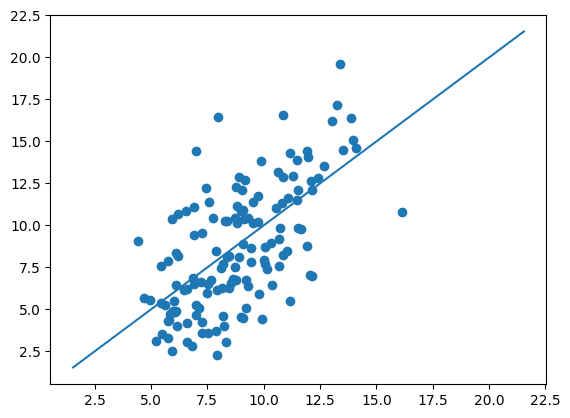

In [212]:
def stat_split (column,input):
    df = input.copy()
    df[column + '_std'] = [x[0] for x in df[column]]
    df[column + '_mean'] = [x[1] for x in df[column]]
    df[column + '_slope'] = [x[2] for x in df[column]]
    df.drop(column,inplace=True,axis=1)
    # df = df[df[column + '_std'] != 0]
    return df

columns = ['player','fpts_game','fpts_game_actual']


wr = stat_split('fpts_game',wr_data_stats[columns])
print(len(wr))

lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', 30, True)


#### Next Trials 
(none more successful, yearly values very close): <br>
compound factor: fpts_game_mean + fpts_game_slope <br>
compound factor: fpts_game_mean + (fpts_game_slope * fpts_game_std) <br>
factors: targets (broken intto mean, slope, std) <br>
compound factor: earned_fpts <br>
factors: fpts_game_mean, fpts_game_slope, earned_fpts <br> 
factors: use list of yearly values for fpts, not fpts stats
<br><br>

In [ ]:
#fpts combound factors
wr['mean_add_slope'] = wr['fpts_game_mean'] + wr['fpts_game_slope']# * wr['fpts_game_std']

slope, intercept = lr_predict(wr,['fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', 30)

wr['predicted'] = wr['fpts_game_mean'] * slope[0] + wr['fpts_game_slope'] * slope[1] + intercept
wr['high'] = wr['predicted'] + wr['fpts_game_std']
wr['low'] = wr['predicted'] - wr['fpts_game_std']
print(len(wr))
print(len(wr[(wr['high'] >= wr['fpts_game_actual']) & (wr['low'] <= wr['fpts_game_actual'])]))

R score  0.34779720630438926
Slope [0.78899116 0.12260949]
Intercept 9.086668426356276
312
123


In [157]:
#earned points and targets
earned_fpts = wr_data['fpts'].sum() / wr_data['targets'].sum()
earned_fpts

columns = ['player','fpts_game','targets_game','fpts_game_actual']

wr = stat_split('fpts_game',wr_data_stats[columns])
wr = stat_split('targets_game', wr)
wr['earned_fpts'] = wr['targets_game_mean'] * earned_fpts

lr_predict(wr,['fpts_game_mean', 'fpts_game_slope', 'earned_fpts'], 'fpts_game_actual', 30, False, False)


(0.3489327116426275,
 array([ 1.17548434,  0.36732656, -0.51187415]),
 2.223773481338701)

R score  0.3635881173530251
Slope [ 0.64958392  0.11257137 -0.07306294 -0.00375638  0.0428161  -0.10554625]
Intercept 2.4147397122194745


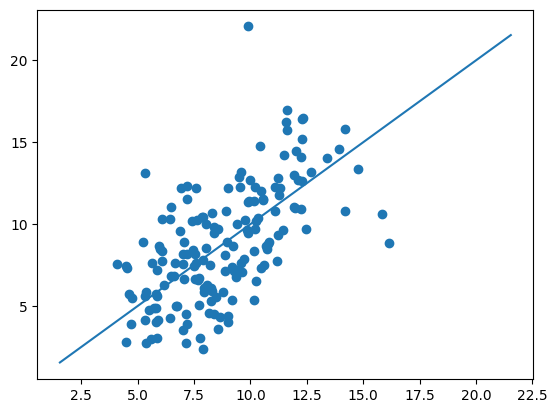

In [211]:
#try true data - start with fantasy points
#create function to split data
def year_split(column, input):
    df = input.copy()
    column_names = []
    for year in range(6):
        year = (year + 1)
        year_neg = year * -1
        column_name = column + str(year_neg)
        df[column_name] = [x[year_neg] if len(x) >= year else 0 for x in df[column]]
        column_names.append(column_name)
    return df, column_names

columns = ['player','fpts_game','fpts_game_actual']
wr_true, factor_columns = year_split('fpts_game', wr_data_true[columns])


r_score, slope, intercept, lr = lr_predict(wr_true,factor_columns, 'fpts_game_actual', 30, True, True)

#### Decide between stats and yearly
The R_score for the stat based and yearly based methods are very close when using the same random seed (30) <br>
run multiple trials to get an average to decide best factors <br>
Result: Stats wins (r = 0.42) over Yearly (r = 0.38)

In [216]:
yearly_rscore = []
stats_rscore = []
for seed in range(100):
    r_score, _, _, _ = lr_predict(wr_true,factor_columns, 'fpts_game_actual', seed, False, False)  
    yearly_rscore.append(r_score)
    r_score, _, _, _ = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], 'fpts_game_actual', seed, False, False)
    stats_rscore.append(r_score)

print('yearly', str(np.mean(yearly_rscore)))
print('stats', str(np.mean(stats_rscore)))

yearly 0.3879388949054279
stats 0.42789079643378153


### Explain Error
based off of the factors found in inital look (fpts_mean, fpts_slope, fpts_std) try to find explaination for error <br>

#### Regression on other factors
first step is to create a measurement of error and to perform linear regression on remaining factors to check for correlation
no factors created an r score better than 0.03 <br>
before this create an average of error based on multiple regression runs with different seeds

In [220]:
#recreate regression for use here
data_columns = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts_game', 'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
columns = data_columns + key_data
wr = stat_split('fpts_game',wr_data_stats[columns])
#calculate average error over repeated samples

error_columns = []
for seed in range(25):
       r_score, slope, intercept, lr = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], key_data[0], seed, False, False)
       #apply to wr list and find difference from actual
       wr['predicted'] = wr['fpts_game_std'] * slope[0] + wr['fpts_game_mean'] * slope[1] + wr['fpts_game_slope'] * slope[2] + intercept
       error_name = 'error'+str(seed)
       error_columns.append(error_name)
       wr[error_name] = wr['predicted'] - wr['fpts_game_actual']

wr['error'] = np.mean(wr[error_columns],axis=1)
wr.drop(error_columns, inplace=True, axis=1)


In [221]:
#determine if any of the other factors can explain the error
#for each data column find the r_score of the regresion for the error
factor_list = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 
               'targets', 'touchdowns', 'wide_rate',
               'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 
               'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
for factor in factor_list:
    wr = stat_split(factor, wr)
    factor_columns = [factor+'_std', factor+'_mean', factor+'_slope']
    r_score, slope, intercept, lr = lr_predict(wr,factor_columns, 'error', 30, False, False)
    print(factor, round(r_score,3))

avg_depth_of_target -0.02
slot_rate -0.03
targeted_qb_rating -0.013
targets 0.006
touchdowns -0.001
wide_rate -0.03
yards_after_catch_per_reception -0.007
yards_per_reception -0.026
yprr -0.055
targets_game 0.012
touchdowns_game 0.008


#### Find other answers

In [269]:
#recreate regression for use here with simplified column list
data_columns = ['fpts_game']
key_data = ['fpts_game_actual']
columns = data_columns + key_data
wr = stat_split('fpts_game',wr_data_stats[columns])
#calculate average error over repeated samples

error_columns = []
predicted_columns = []
r_scores = []
for seed in range(25):
       r_score, slope, intercept, lr = lr_predict(wr,['fpts_game_std', 'fpts_game_mean', 'fpts_game_slope'], key_data[0], seed, False, False)
       r_scores.append(r_score)
       #apply to wr list and find difference from actual
       wr['predicted'] = wr['fpts_game_std'] * slope[0] + wr['fpts_game_mean'] * slope[1] + wr['fpts_game_slope'] * slope[2] + intercept
       error_name = 'error'+str(seed)
       error_columns.append(error_name)
       predicted_name = 'predicted'+str(seed)
       predicted_columns.append(predicted_name)
       wr[error_name] = wr['predicted'] - wr['fpts_game_actual']
       wr[predicted_name] = wr['predicted']

wr['predicted'] = np.mean(wr[predicted_columns], axis=1)
wr.drop(predicted_columns, inplace=True, axis=1)
wr['error'] = np.mean(wr[error_columns], axis=1)
wr.drop(error_columns, inplace=True, axis=1)
wr = wr[['fpts_game_mean', 'fpts_game_std','fpts_game_slope','fpts_game_actual','predicted','error']]
wr['abs_error'] = np.absolute(wr['error'])

##### Absolute Error
Check if error is related to magnitude of fantasy points, check the same for absolute value of error <br>
check if other factors are more closely related to absolute error than regular error none more than r=0.05<br>

In [242]:
#determine if any of the other factors can explain the error
#for each data column find the r_score of the regresion for the error
factor_list = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 
               'targets', 'touchdowns', 'wide_rate',
               'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 
               'targets_game', 'touchdowns_game']
key_data = ['fpts_game_actual']
for factor in factor_list:
    wr_temp = stat_split(factor, wr_data_stats)
    factor_columns = [factor+'_std', factor+'_mean', factor+'_slope']
    for sub_factor in factor_columns:
        wr[sub_factor] = wr_temp[sub_factor]
    r_score, slope, intercept, lr = lr_predict(wr,factor_columns, 'abs_error', 30, False, False)
    print(factor, round(r_score,3))

avg_depth_of_target -0.008
slot_rate -0.048
targeted_qb_rating -0.025
targets -0.018
touchdowns -0.002
wide_rate -0.047
yards_after_catch_per_reception -0.03
yards_per_reception 0.006
yprr 0.015
targets_game 0.011
touchdowns_game -0.019


##### Evaluate Situation Changes
measure tumult, new team, new WR on team <br>
next: new coach, new QB

###### New Team
CONCLUSION: <br>
new team penalty of -2 will be included in calculations

In [374]:
#determine if they have a new team
#will also determine for all other wrs on that team if the have a new teammate
wr_tumult = wr.copy()
wr_tumult = pd.merge(wr_tumult, wr_data_stats[['player', 'year']], 'left', left_index=True, right_index=True)
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'year'], right_on=['player', 'year'])
wr_tumult['last_year'] = wr_tumult['year'] - 1
wr_tumult = pd.merge(wr_tumult, wr_data[['player', 'year', 'team_name']], 'left', left_on=['player', 'last_year'], right_on=['player', 'year'])
wr_tumult.rename(columns={'year_x': 'year', 'team_name_x': 'team_name', 'team_name_y': 'last_team'}, inplace=True)
wr_tumult.drop('year_y', inplace=True, axis=1)
wr_tumult['same_team'] = wr_tumult['team_name'] == wr_tumult['last_team']


new team quartiles: [-0.58, 1.72, 3.54]
same team quartiles: [-2.24, -0.35, 1.4]
mean quartile diff:  1.9566666666666668


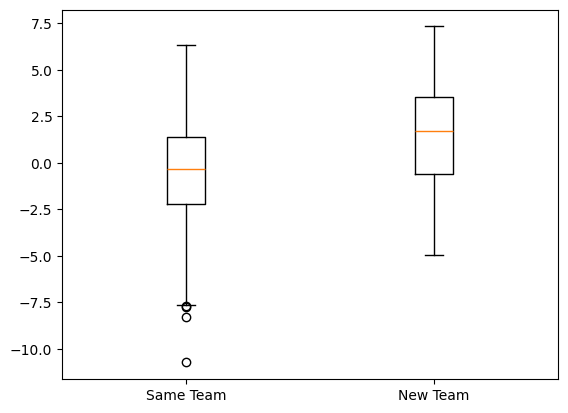

In [362]:
#plot each wr if they have a new team
plt.boxplot([wr_tumult[wr_tumult['same_team'] == True]['error'], wr_tumult[wr_tumult['same_team'] == False]['error']], tick_labels=['Same Team', 'New Team'])
new_team_quarts = []
same_team_quarts = []
for quart in [0.25, 0.5, 0.75]:
    new_team_quarts.append(round(wr_tumult[wr_tumult['same_team'] == False]['error'].quantile(quart),2))
    same_team_quarts.append(round(wr_tumult[wr_tumult['same_team'] == True]['error'].quantile(quart),2))
quartile_diff = [new_team_quarts[0]-same_team_quarts[0],new_team_quarts[1]-same_team_quarts[1],new_team_quarts[2]-same_team_quarts[2]]
print('new team quartiles:', str(new_team_quarts))
print('same team quartiles:', str(same_team_quarts))
print('mean quartile diff: ', str(np.mean(quartile_diff)))

there is clear difference between players going to a new team: all quartiles are ~ +2 more error <br>
This indicates that players that go to a new team are overestimated by 2 points/game

In [375]:
#find the teams that had a new WR and the best average points/game that they added
#this should be a representation of wether a team added a good new WR or just some guy
team_new_wr = wr_tumult.loc[wr_tumult['same_team'] == False,['fpts_game_mean','team_name','year']].groupby(['team_name','year']).max()

wr_tumult['new_wr'] = [team_new_wr.loc[(row[1]['team_name'],int(row[1]['year'])),'fpts_game_mean'] 
 if (row[1]['team_name'], int(row[1]['year'])) in team_new_wr.index
 else 0
 for row in wr_tumult[['team_name','year']].iterrows()]


no good wr added;  [-2.11, -0.05, 1.82]
good wr added:  [-1.43, 0.76, 3.09]
mean quartile differences:  0.92


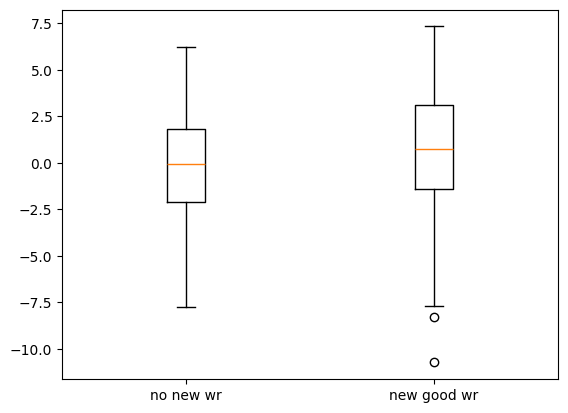

In [364]:
#10 has highest difference while keeping a large sample size (0.92, 108)
good_wr_line = 10

#find cutoff that makes the biggest difference
for cutoff in range(1,int(max(wr_tumult['new_wr']))):
    no_wr_quarts = []
    new_wr_quarts = []
    for quart in [0.25, 0.5, 0.75]:
        no_wr_quarts.append(round(wr_tumult[wr_tumult['new_wr'] <= cutoff]['error'].quantile(quart),2))
        new_wr_quarts.append(round(wr_tumult[wr_tumult['new_wr'] > cutoff]['error'].quantile(quart),2))
    quartile_diff = [new_wr_quarts[0]-no_wr_quarts[0],new_wr_quarts[1]-no_wr_quarts[1],new_wr_quarts[2]-no_wr_quarts[2]]
    if cutoff == good_wr_line:
        print('no good wr added; ', str(no_wr_quarts))
        print('good wr added: ', str(new_wr_quarts))
        print('mean quartile differences: ', str(round(np.mean(quartile_diff),2)))



plt.boxplot([wr_tumult[wr_tumult['new_wr'] <= good_wr_line]['error'], wr_tumult[wr_tumult['new_wr'] > good_wr_line]['error']], tick_labels=['no new wr', 'new good wr'])
plt.show()

there is discernable difference between players that get a new good teammate and others: average quartile is ~ +1 higher error <br>
This indicates that players that get a good new teammate are overestimated by about 1 point per/game
<br><br>
bring both of these ideas together into main calculation

In [371]:
#include a 2 point pentaly for being on a new team
#calcualte current state
mean_sq_err = (wr_tumult['error']**2).mean()
print('MSE Base', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['predicted'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score base: ', str(round(np.mean(r_scores),3)))


#calcualte new state
wr_tumult['ajd_prediction'] = wr_tumult['predicted'] + (1 - wr_tumult['same_team'].astype(int)) * -2
wr_tumult['adj_error'] = wr_tumult['ajd_prediction'] - wr_tumult['fpts_game_actual']
mean_sq_err = (wr_tumult['adj_error']**2).mean()
print('MSE adjusted', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['ajd_prediction'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score adjusted: ', str(round(np.mean(r_scores),3)))

MSE Base 8.176
r score base:  0.406
MSE adjusted 7.81
r score adjusted:  0.443


In [373]:
#calcualte new state
good_wr_line = 10
wr_tumult['ajd_prediction'] = wr_tumult['ajd_prediction'] + (wr_tumult['new_wr'] > good_wr_line).astype(int) * -1
wr_tumult['adj_error'] = wr_tumult['ajd_prediction'] - wr_tumult['fpts_game_actual']
mean_sq_err = (wr_tumult['adj_error']**2).mean()
print('MSE adjusted', str(round(mean_sq_err,3)))
#calculate r_score over multiple samples
r_scores = []
for seed in range(25):
    r_score, slope, intercept, lr = lr_predict(wr_tumult,['ajd_prediction'], 'fpts_game_actual', seed, False, False)
    r_scores.append(r_score)
print('r score adjusted: ', str(round(np.mean(r_scores),3)))

MSE adjusted 8.221
r score adjusted:  0.434


RESULTS with just new team penalty: <br>
MSE Base 8.176<br>
r score base:  0.406<br>
MSE adjusted 7.81<br>
r score adjusted:  0.443<br>
<br><br>
RESULTS with new team penalty new teammate penalty: <br>
MSE adjusted 8.221<br>
r score adjusted:  0.434<br>

CONCLUSION: <br>
new team penalty of -2 will be included in calculations

Also tested: <br>
new factor: value of wr lost from team - had no afffect <br>
tested: new_wr, wr_lost and wr_added_better as a linear regression input - no affect

###### New coach